# Projet réalisé par : Oussama EL ALOUI et Benkhanous SALAHEDDINE
-------------------------------------------------------------------

# Remarque Importante:
* Pour executer le modèle directement pour verifier le résultat de la classification , il suffit de basculer vers le bas  ( Partie execution )



In [ ]:
#Chargement des bibliothèques
import os
import numpy as np

#Chargement des fonctions à partir la bibliothèque tensorflow.keras pour la classification d'image
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.models import load_model, Sequential
import tensorflow as tf


In [ ]:
#Chargement de base de données d'images
!wget -O dataset.zip https://www.dropbox.com/scl/fi/w6a9k9k1agp341drlpkkq/Images.zip?rlkey=n5mjuy5y0ybi1bxxq5pfvqc4v&st=v700u5uo&dl=0
!unzip dataset.zip

--2024-05-24 11:39:46--  https://www.dropbox.com/scl/fi/w6a9k9k1agp341drlpkkq/Images.zip?rlkey=n5mjuy5y0ybi1bxxq5pfvqc4v
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc25756ee582e4af145fd58af1cf.dl.dropboxusercontent.com/cd/0/inline/CTgm8XyHypyD2uPxXUWckK1M7WZS9uUuaAGzKSpcTxww0ZnUTqpctUBk5L1jPpQI4JBEt4p2XTp1xGOtJARSNI_WalDj3nfEs56tGm0IgS2H7Fll9FNG4VAtTUA9Rb6LsY7WG8CVdilZlhwgcWcMsCEw/file# [following]
--2024-05-24 11:39:47--  https://uc25756ee582e4af145fd58af1cf.dl.dropboxusercontent.com/cd/0/inline/CTgm8XyHypyD2uPxXUWckK1M7WZS9uUuaAGzKSpcTxww0ZnUTqpctUBk5L1jPpQI4JBEt4p2XTp1xGOtJARSNI_WalDj3nfEs56tGm0IgS2H7Fll9FNG4VAtTUA9Rb6LsY7WG8CVdilZlhwgcWcMsCEw/file
Resolving uc25756ee582e4af145fd58af1cf.dl.dropboxusercontent.com (uc25756ee582e4af145fd58af1cf.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100

In [ ]:
#Lecture de dossier d'images
count = 0
images_hub = os.listdir('flowers/')
for dir in images_hub:
    images = list(os.listdir('flowers/'+dir))
    print( '>> Dossier \''+dir +'\'contient '+ str(len(images)) + ' images')
    count = count + len(images)
print( '---------> TOTAL d\'images : '+ str(count))

>> Dossier 'dandelion'contient 1052 images
>> Dossier 'rose'contient 784 images
>> Dossier 'daisy'contient 764 images
>> Dossier 'sunflower'contient 733 images
>> Dossier 'tulip'contient 984 images
---------> TOTAL d'images : 4317


In [ ]:
images_dir = 'flowers'
img_size = 180
batch = 32  # càd pour chaque collection d'image , l'algorithme s'entrainne à la fois sur 32 images

# Partie de séparation des données

## Données d'entrainement
*  Utiliser 80 % des données pour l'entraînement (et implicitement, les 20 % restants pour la validation c'est à dire pour verifier la classification prédite par notre modèle).

In [ ]:
training_dataset = tf.keras.utils.image_dataset_from_directory( images_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))


Found 4317 files belonging to 5 classes.
Using 3454 files for training.


# Données de classification


*   Ces données seront utilisés pour prédire leurs types ( classes ) par notre

* Utiliser 80 % des données pour l'entraînement (et implicitement, les 20 % restants pour la validation c'est à dire pour verifier la classification prédite par notre modèle).

In [ ]:

validation_dataset = tf.keras.utils.image_dataset_from_directory( images_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
flowers_classes = training_dataset.class_names
flowers_classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

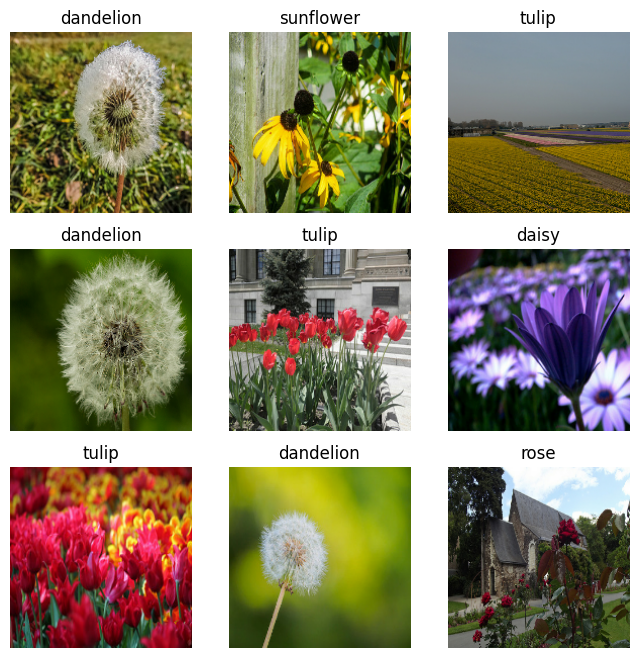

In [ ]:
import matplotlib.pyplot as plt
i = 0
plt.figure(figsize=(8,8))

for images, labels in training_dataset.take(5): # afficher la 5eme lot ( collection d'image de taille 32 images)
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flowers_classes[labels[i]])
        plt.axis('off')

In [ ]:
#pour améliorer l'efficacité du traitement des données automatiquement , on utilise l'option AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

## Mélanger les données est important pour éviter les patterns répétitifs pendant l'entraînement, ce qui aide à généraliser le modèle.
### On va mélanger 1000 images pour les 2 types de données.

In [ ]:
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
validation_dataset = validation_dataset.cache().prefetch(buffer_size = AUTOTUNE)

# Augmentation des données :
* une technique permettant d'augmenter la diversité des données d'entraînement en appliquant des transformations aléatoires mais réalistes telles que la rotation d'image, le zoom et le positionnement.

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

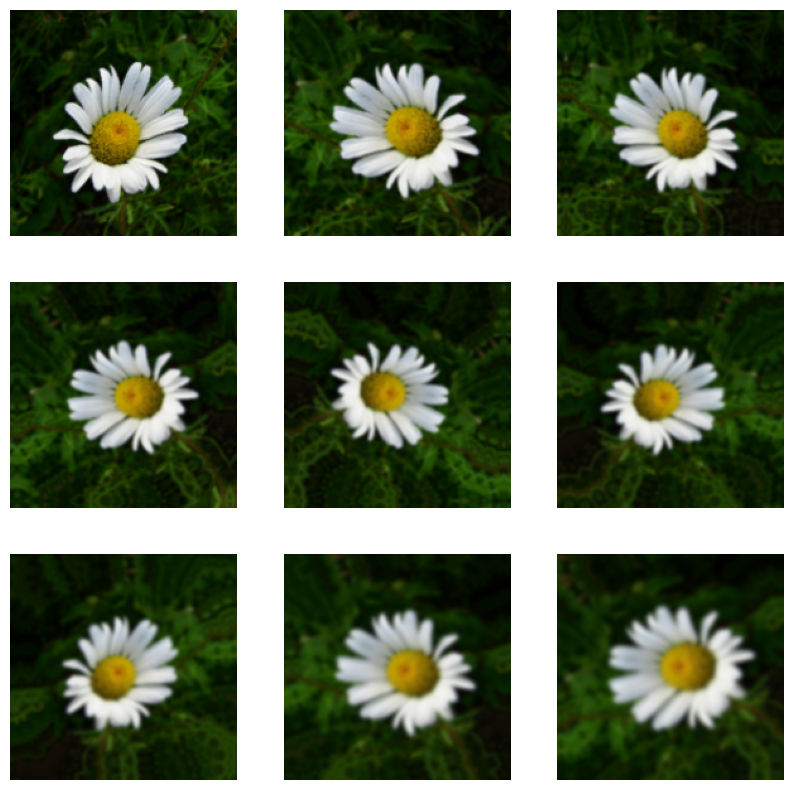

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in training_dataset.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[2].numpy().astype('uint8'))
        plt.axis('off')

# Partie Machine Learning

### Initialisation de modèle de type réseau de neurone.

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

# Compiler et entraîner le modèle

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Résumé fournit des détails sur l'architecture de modèle

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

# Phase d'entrainement de modèle

In [ ]:
history = model.fit(training_dataset, epochs=15, validation_data=validation_dataset)

Epoch 1/15
108/108 [==============================] - 160s 1s/step - loss: 1.2999 - accuracy: 0.4461 - val_loss: 1.1460 - val_accuracy: 0.5214
Epoch 2/15
108/108 [==============================] - 142s 1s/step - loss: 1.0439 - accuracy: 0.5851 - val_loss: 1.0166 - val_accuracy: 0.6025
Epoch 3/15
108/108 [==============================] - 144s 1s/step - loss: 0.9713 - accuracy: 0.6155 - val_loss: 0.9617 - val_accuracy: 0.6083
Epoch 4/15
108/108 [==============================] - 142s 1s/step - loss: 0.8965 - accuracy: 0.6523 - val_loss: 0.8734 - val_accuracy: 0.6547
Epoch 5/15
108/108 [==============================] - 141s 1s/step - loss: 0.8452 - accuracy: 0.6769 - val_loss: 0.8445 - val_accuracy: 0.6616
Epoch 6/15
108/108 [==============================] - 140s 1s/step - loss: 0.8189 - accuracy: 0.6792 - val_loss: 0.8610 - val_accuracy: 0.6582
Epoch 7/15
108/108 [==============================] - 137s 1s/step - loss: 0.7720 - accuracy: 0.6980 - val_loss: 0.8576 - val_accuracy: 0.6628

# Visualisez les résultats de l'entraînement

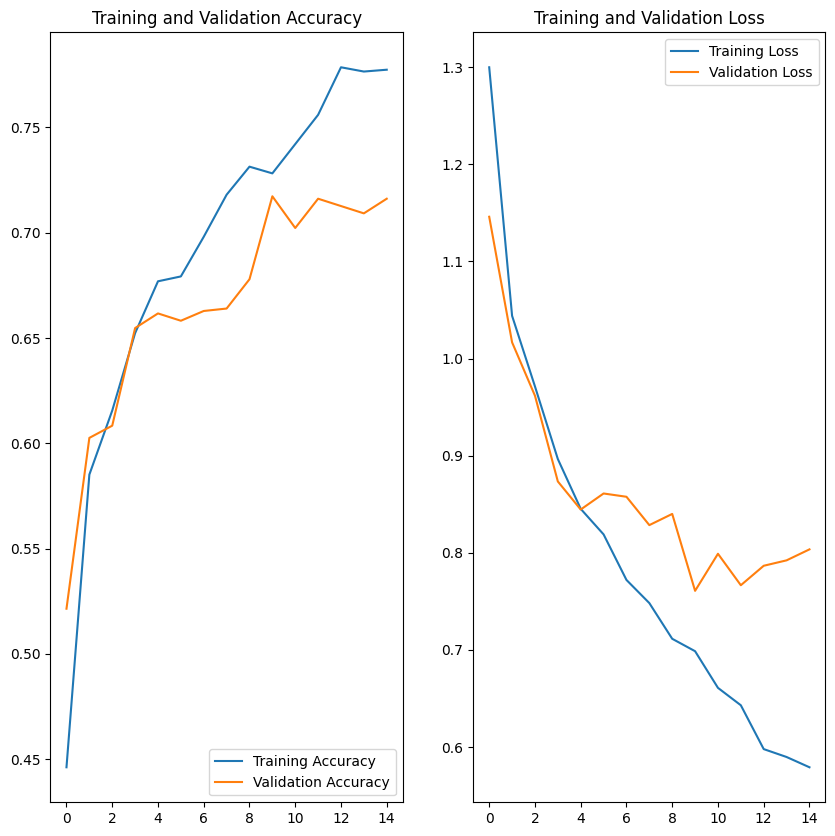

In [ ]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"Test accuracy: {test_acc}")

27/27 [==============================] - 8s 267ms/step - loss: 0.8035 - accuracy: 0.7161
Test accuracy: 0.7161065936088562


# Partie Execution

* Pour tester le  modèle ( déja enregistré apres sa phase d'entrainement ) :


1.   Metrre le fichier 'model_alpha.h5' dans le projet colab
2. Executer la cellule ci-dessous


In [ ]:
model = load_model('model_alpha.h5')

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = '>> Image est de classe {' + flowers_classes[np.argmax(result)] + '} avec un score de '+ str(np.max(result)*100)
    return outcome

In [ ]:
classify_images('flowers/dandelion/10043234166_e6dd915111_n.jpg')
#normalement la classe d'image est : dandelion , on verra la classification prédite par notre modèle :

1/1 [==============================] - 0s 36ms/step


'>> Image est de classe {dandelion} avec un score de 98.61971735954285'

In [ ]:
model.save('model_alpha.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
